In [1]:
import pandas as pd

In [2]:

df = pd.read_csv('recons-iter.csv')


In [3]:
df


,Refs,Reads
0,ACCATAATGCGTGGGGCCGACCTCGGAATGCGGTCTCCATGCGCGT...,ACCATAATGCGTGGGGCCGACCTCGGAATGCGGTCTCCATGCGCGT...
1,TCGAAGCAGTAGGGCCTACCAAATAGGTTGGTCCTCCGTTGTATCT...,TCGAAGCAGTAGGGCCTACCAAATAGGTTGGTCCTCCGTTGTATCT...
2,AGTTAACGTCCCACGGCGAGGCACTCTTGATCCCCACCTTCAAGAG...,AGTTAACGTCCCACGGCGAGGCACTCTTGATCCCCACCTTCAAGAG...
3,GCCCAAGGGTACGCCCGCAGCGACGCAATTGGCGGAGTAAGCGCGT...,GCCCAAGGGTACGCCCGCAGCGACGCAAATTGGCGGAGTAAGCGCG...
4,GCACTGATGTAACTCATGGTACATCCGTCGCTGAGCGCCATTTTGT...,GCACTGATGTAACTCATGGTACATCCGTCGCTGAGCGCCATTTTGT...
...,...,...
9995,GCATGATTTGGAAGGTCGGCACTATACCCACCCAGGGTATATGGTC...,GCATGATTTGGAAGGTCGGCACTATACCCACCCAGGGTATATGGTC...
9996,GAAGTTTGGAACGTGTTCGTCCGCCAATTAAGGTTGGCTTCTAGTA...,GAAGTTTGGAACGTGTTCGTCCGCCAATTAAGGTTGGCTTCTAGTA...
9997,TGCATCCCGGACAACCGCAAGGGTGCATGGGCACCGCAATTCCCAA...,TGCATCCCGGACAACCGCAAGGGTGCATGGGCACCGCAATTCCCAA...
9998,ACTGGACGTCCTATGCTGGCATAATGAAACGACAACCTGTCTTCGA...,ACTGGACGTCCTATGCTGGCATAATGAAACGACAACCTGTCTTCGA...


In [4]:
from tqdm import tqdm


In [5]:
noisy_strands = [s.strip() for s in list(df['Reads'])]


In [6]:
ref_strands = [s.strip() for s in list(df['Refs'])]


In [7]:
import difflib


In [8]:
import matplotlib.pyplot as plt
import numpy as np
import os

# use LaTeX fonts in the plot
plt.rc('text', usetex=True)
plt.rc('font', family='serif')
os.environ["PATH"] += os.pathsep + '/usr/local/texlive/2021basic/bin/universal-darwin'

In [9]:
def print_diff(ref_strand, noisy_strand):
    global pairs
    global pairs_no_pos
    a, b = 0, 0

    # quadratic time, no heuristics
    for match in difflib.SequenceMatcher(None, ref_strand, noisy_strand, autojunk=False).get_matching_blocks():
        was = ref_strand[a:match.a]
        now = noisy_strand[b:match.b]
        
        a = match.a + match.size
        b = match.b + match.size
        
        if was == '' and now == '':
            pass
        else:
            # print('{}|{}'.format(was, now), end=', ')
            pairs += [(was, now, match.a)]
            pairs_no_pos += [(was, now)]



100%|██████████| 10000/10000 [00:00<00:00, 87956.72it/s]


[33, 88, 92, 97, 105, 117, 136, 138, 158, 146, 152, 173, 174, 187, 180, 210, 205, 221, 214, 232, 239, 258, 261, 277, 270, 293, 298, 301, 311, 321, 315, 328, 342, 353, 377, 370, 408, 382, 403, 429, 443, 432, 453, 451, 468, 463, 486, 477, 490, 505, 498, 524, 515, 518, 529, 558, 550, 569, 603, 582, 621, 616, 614, 623, 645, 642, 634, 666, 680, 684, 697, 698, 707, 720, 741, 743, 744, 765, 765, 783, 758, 780, 809, 830, 822, 838, 831, 826, 862, 851, 864, 896, 909, 918, 922, 923, 927, 930, 939, 963, 933, 989, 1009, 1004, 1013, 1005, 1048, 1026, 1042, 2121]


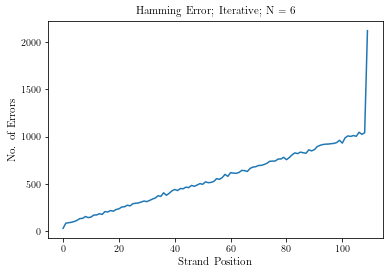

In [10]:
# Hamming Distance Graph
strand_len = 110
count_pos = [0] * (strand_len + 1)

def hamming(ref_strand, recons_strand):
    for i, (c1, c2) in enumerate(zip(ref_strand, recons_strand)):
        if c1 != c2:
            count_pos[i] += 1

for i in tqdm(range(len(ref_strands))):
    hamming(ref_strands[i], noisy_strands[i])

print(count_pos[:-1])
f = plt.figure()
plt.plot(range(strand_len), count_pos[:-1])
plt.title(r'Hamming Error; Iterative; N = 6', fontsize=11)
plt.xlabel(r'Strand Position', fontsize=11)
plt.ylabel(r'No. of Errors', fontsize=11)
plt.show()
f.savefig('cov6-iter-hamming.pdf', bbox_inches='tight')

In [11]:
pairs = []
pairs_no_pos = []

for i in tqdm(range(len(ref_strands))):
    if ref_strands[i] != noisy_strands[i]:
        print_diff(ref_strands[i], noisy_strands[i])


100%|██████████| 10000/10000 [00:02<00:00, 4701.45it/s]


In [12]:

subs_no_pos, counts_no_pos = np.unique(pairs_no_pos, return_counts=True, axis=0)
sorting = np.argsort(counts_no_pos)
subs_no_pos = subs_no_pos[sorting]
counts_no_pos = counts_no_pos[sorting]

for sub, count in zip(subs_no_pos, counts_no_pos):
    if count > 5:
        print("{} -> {}".format(sub[0], sub[1]), count)


G -> A 13
G -> T 15
A -> G 17
G -> C 17
C -> A 17
C -> T 18
T -> G 18
A -> C 18
T -> A 20
C -> G 20
T -> C 21
A -> T 21
G ->  43
C ->  50
A ->  50
T ->  65
 -> A 546
 -> C 637
 -> G 655
 -> T 681


 -> G @ 5 6
 -> G @ 80 6
 -> C @ 20 6
 -> C @ 21 6
 -> C @ 33 6
 -> C @ 71 6
 -> C @ 73 6
 -> C @ 8 6
 -> C @ 88 6
 -> C @ 89 6
 -> G @ 105 6
 -> A @ 88 6
 -> G @ 64 6
 -> G @ 67 6
 -> G @ 82 6
 -> G @ 99 6
 -> A @ 82 6
 -> C @ 11 6
 -> T @ 96 6
 -> T @ 86 6
 -> T @ 98 6
 -> T @ 27 6
 -> T @ 89 6
 -> T @ 75 6
 -> T @ 34 6
 -> G @ 63 7
 -> G @ 108 7
 -> T @ 20 7
 -> T @ 70 7
 -> T @ 92 7
 -> G @ 88 7
 -> G @ 91 7
 -> G @ 95 7
 -> T @ 11 7
 -> A @ 39 7
 -> C @ 38 7
 -> A @ 1 8
 -> G @ 102 8
 -> C @ 69 9
 -> G @ 106 10
C -> A @ 110 12
G -> A @ 110 12
G -> T @ 110 12
 -> C @ 1 13
 -> T @ 1 13
C -> T @ 110 14
A -> G @ 110 14
 -> G @ 1 14
G -> C @ 110 15
A -> C @ 110 15
 -> T @ 0 15
 -> G @ 0 15
T -> A @ 110 16
T -> G @ 110 17
T -> C @ 110 18
A -> T @ 110 18
C -> G @ 110 18
 -> C @ 0 21
 -> A @ 0 27
G ->  @ 110 31
C ->  @ 110 36
A ->  @ 110 39
 -> A @ 110 44
 -> C @ 110 47
T ->  @ 110 49
 -> T @ 110 55
 -> G @ 110 65
 -> G @ 109 223
 -> A @ 109 224
 -> C @ 109 233
 -> T @ 109 260
[79, 48, 19

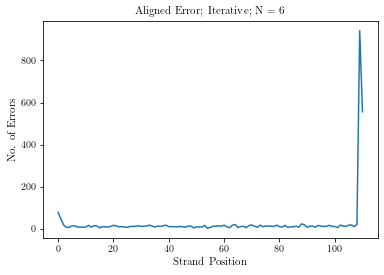

In [13]:
subs, counts = np.unique(pairs, return_counts=True, axis=0)
sorting = np.argsort(counts)
subs = subs[sorting]
counts = counts[sorting]

for sub, count in zip(subs, counts):
    if count > 5:
        print("{} -> {} @ {}".format(sub[0], sub[1], sub[2]), count)

strand_len = 110
pos_counts = [0] * (strand_len + 1)
for sub, count in zip(subs, counts):
    pos_counts[int(sub[2])] += count

print(pos_counts)

f = plt.figure()
plt.plot(range(strand_len + 1), pos_counts)
plt.title(r'Aligned Error; Iterative; N = 6', fontsize=11)
plt.xlabel(r'Strand Position', fontsize=11)
plt.ylabel(r'No. of Errors', fontsize=11)
plt.show()
f.savefig('cov6-iter-aligned.pdf', bbox_inches='tight')

In [14]:
subs, counts = np.unique(pairs, return_counts=True, axis=0)
sorting = np.argsort(counts)
subs = subs[sorting]
counts = counts[sorting]


In [15]:
def get_key(char1, char2):
    char1 = char1 if char1 != '' else '_'
    char2 = char2 if char2 != '' else '_'
    return char1 + ' -> ' + char2

strand_len = 110
pos_map = {}
pos_counts = [0] * (strand_len + 1)
for sub, count in zip(subs, counts):
    key = get_key(sub[0], sub[1])
    if key not in pos_map:
        pos_map[key] = [0] * (strand_len + 1)
    pos_map[key][int(sub[2])] += count

In [16]:
sub_keys = [get_key(sub[0], sub[1]) for sub in subs_no_pos]
max_10_keys = sub_keys[-10:]
max_10_counts = counts_no_pos[-10:]


[15, 13, 2, 0, 3, 4, 5, 3, 0, 3, 4, 7, 3, 5, 2, 1, 2, 3, 3, 5, 7, 4, 1, 1, 4, 4, 2, 6, 3, 4, 3, 4, 5, 4, 6, 1, 4, 4, 0, 2, 5, 4, 3, 1, 5, 2, 3, 4, 4, 1, 3, 2, 4, 5, 0, 2, 3, 1, 4, 3, 5, 1, 0, 5, 5, 1, 2, 1, 1, 3, 7, 0, 3, 3, 3, 6, 5, 5, 1, 4, 0, 3, 1, 2, 3, 2, 6, 2, 5, 6, 1, 3, 7, 3, 4, 4, 6, 4, 6, 2, 1, 2, 1, 3, 5, 4, 3, 1, 4, 260, 55]
[15, 14, 2, 4, 2, 6, 3, 3, 2, 1, 1, 3, 3, 2, 2, 2, 2, 1, 1, 0, 3, 3, 3, 5, 2, 0, 4, 1, 5, 5, 2, 2, 2, 4, 3, 2, 1, 5, 1, 4, 1, 2, 3, 2, 3, 2, 2, 1, 2, 3, 1, 3, 1, 4, 1, 1, 4, 5, 4, 2, 4, 2, 4, 7, 6, 3, 2, 6, 4, 2, 4, 2, 2, 5, 5, 3, 2, 1, 5, 4, 6, 3, 6, 1, 2, 3, 3, 1, 7, 3, 1, 7, 3, 0, 4, 7, 3, 4, 4, 6, 3, 2, 8, 5, 3, 6, 10, 3, 7, 223, 65]
[21, 13, 4, 2, 0, 2, 4, 3, 6, 1, 0, 6, 1, 4, 4, 2, 5, 2, 4, 3, 6, 6, 3, 4, 1, 1, 2, 2, 3, 3, 3, 5, 5, 6, 1, 1, 4, 2, 7, 4, 1, 3, 4, 5, 2, 4, 1, 2, 4, 1, 3, 1, 2, 3, 1, 1, 4, 3, 5, 3, 5, 4, 1, 3, 4, 2, 5, 5, 1, 9, 3, 6, 2, 6, 0, 4, 3, 4, 3, 3, 2, 1, 3, 1, 2, 1, 1, 2, 6, 6, 2, 2, 2, 0, 4, 0, 2, 2, 4, 4, 4, 2, 5, 3, 1, 4, 

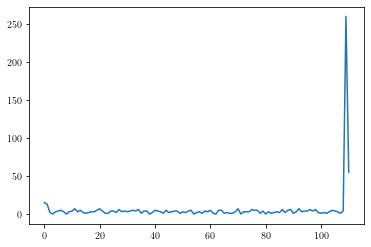

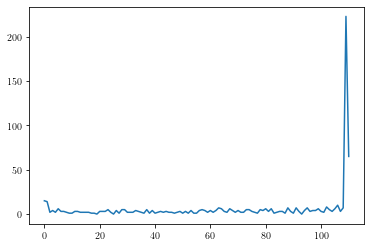

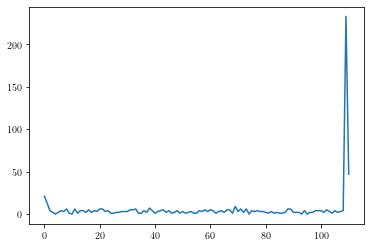

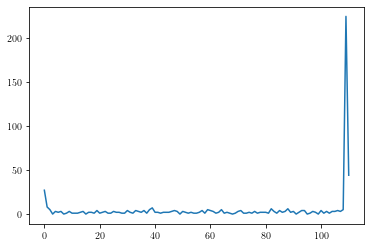

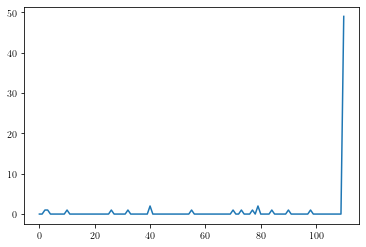

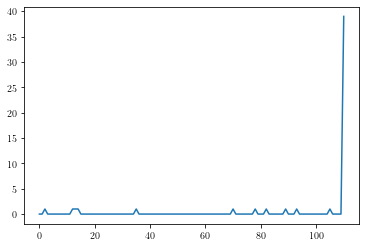

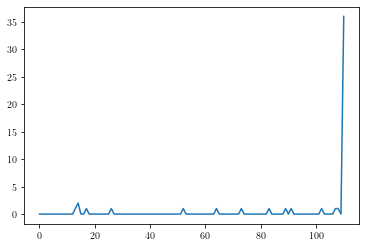

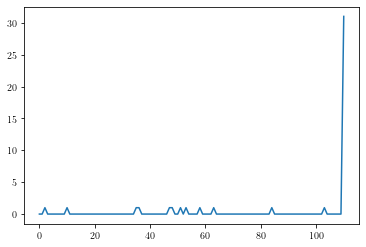

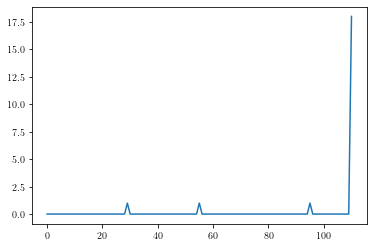

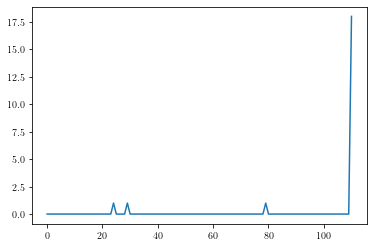

In [17]:
for key, count in zip(reversed(max_10_keys), reversed(max_10_counts)):
    plt.figure(key)
    print(pos_map[key])
    plt.plot(range(strand_len + 1), pos_map[key])

In [18]:
np.save('subs.npy', subs)
np.save('counts.npy', counts)